## 4. Evaluation Metrics for Classification

### 4.1 Evaluation metrics: Overview

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test =  train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values 
y_test = df_test.churn.values 

del df_train['churn']
del df_val['churn']
del df_test['churn']


In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
        'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [6]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression()

model.fit(X_train, y_train)


LogisticRegression()

In [7]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

### 4.2 Accuracy and Dummy Model

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1132

In [10]:
# change threshold

thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print(f"threshold {t} : score {score}")
    scores.append(score)



threshold 0.0 : score 0.2739531582682754
threshold 0.05 : score 0.5088715400993612
threshold 0.1 : score 0.5911994322214337
threshold 0.15000000000000002 : score 0.6664300922640171
threshold 0.2 : score 0.7097232079489
threshold 0.25 : score 0.7388218594748048
threshold 0.30000000000000004 : score 0.7601135557132718
threshold 0.35000000000000003 : score 0.7721788502484032
threshold 0.4 : score 0.7849538679914834
threshold 0.45 : score 0.7934705464868701
threshold 0.5 : score 0.8034066713981547
threshold 0.55 : score 0.801277501774308
threshold 0.6000000000000001 : score 0.794889992902768
threshold 0.65 : score 0.7863733144073811
threshold 0.7000000000000001 : score 0.765791341376863
threshold 0.75 : score 0.7444996451383961
threshold 0.8 : score 0.7345635202271115
threshold 0.8500000000000001 : score 0.7260468417317246
threshold 0.9 : score 0.7260468417317246
threshold 0.9500000000000001 : score 0.7260468417317246
threshold 1.0 : score 0.7260468417317246


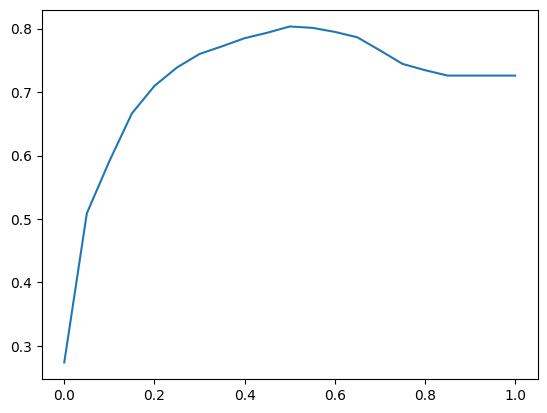

In [11]:
plt.plot(thresholds,scores)

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [13]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1409})

In [14]:
Counter(y_val)   ##Class imbalance

Counter({0: 1023, 1: 386})

### 4.3 Confusion Table

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [18]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [19]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [20]:
confusion_matrix / confusion_matrix.sum()


array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

### 4.4 Precision and Recall

In [21]:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

In [22]:
#precision - tells how many positive predictiosn end up as correct
p = tp / (tp + fp)
p

0.6752411575562701

In [23]:
#recall - tells how many positive ovservations end up being predicted as correct
r = tp / (tp + fn)
r

0.5440414507772021

### 4.5 ROC Curves

#### TPR and FRP

In [24]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tpr, fpr

(0.5440414507772021, 0.09872922776148582)

In [25]:
thresholds = np.linspace(0, 1, 101)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))


In [26]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [27]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr']  = df_scores.fp / (df_scores.fp + df_scores.tn)

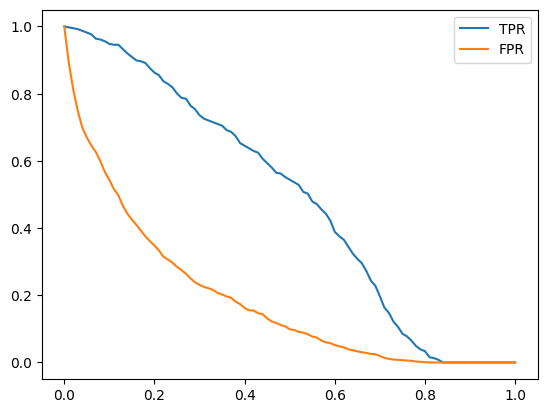

In [28]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

#### Random Model

In [29]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))

In [30]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [31]:
def tpr_fpr_df(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr']  = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores
        


In [32]:
df_rand = tpr_fpr_df(y_val, y_rand)

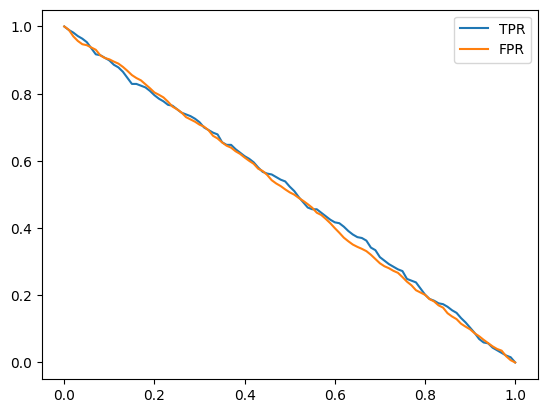

In [33]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

Ideal model

In [34]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [35]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [36]:
y_ideal_pred = np.linspace(0,1, len(y_val))

In [37]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [38]:
df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)

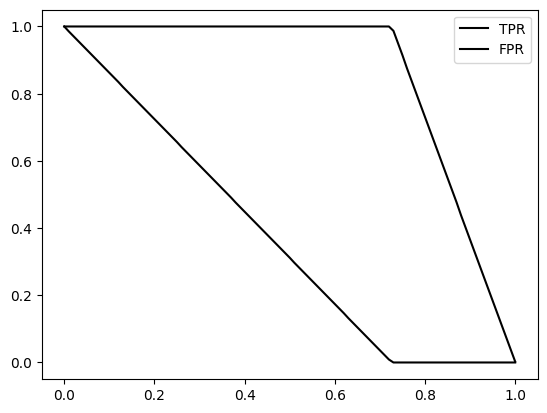

In [39]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color='black')
plt.legend()



Putting Everything Together

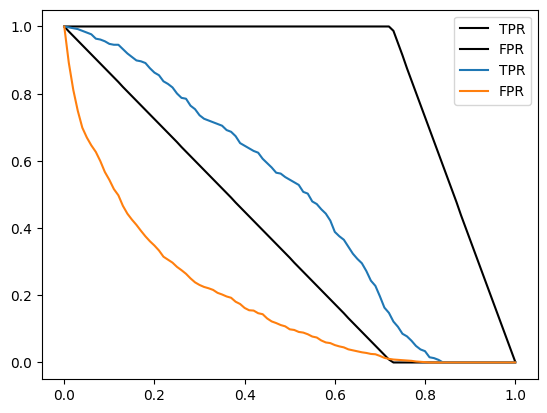

In [40]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color='black')
plt.legend()
# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
# plt.legend()

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

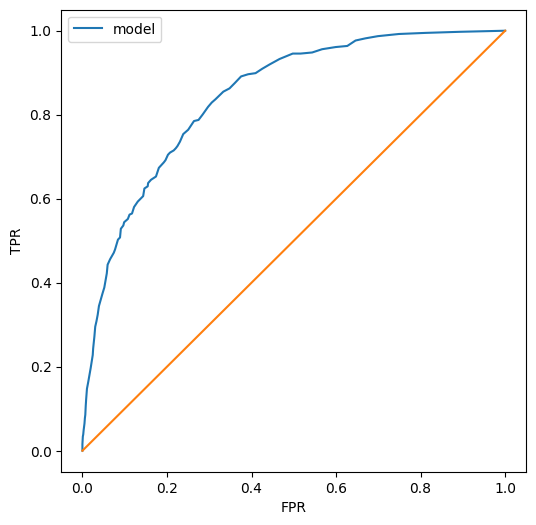

In [41]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1])
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [42]:
#plot auc curves with sklearn

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

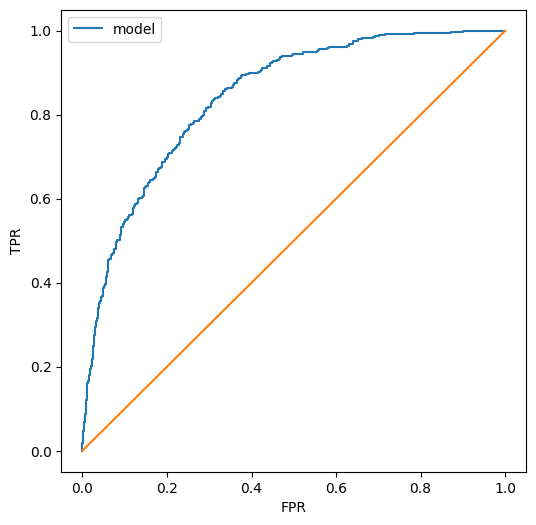

In [43]:
plt.figure(figsize=(6,6))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1])
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### 4.6 ROC AUC

In [44]:
from sklearn.metrics import auc

In [45]:
auc(fpr, tpr)

0.8438479732980819

In [46]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [47]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.8438479732980819

In [49]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [50]:
import random

n = 100_000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84314

In [51]:
n = 10_000
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

In [52]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.8352

### 4.7 Cross-Validation

In [53]:
def train(df, y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y)


    return dv, model

In [54]:
dv, model = train(df_train, y_train)

In [55]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [56]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm




for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C={C} {np.mean(scores)} +- {np.std(scores)}')


c:\Users\khanm375\Documents\ml_zoom\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:01<00:09,  1.52s/it]

C=0.001 0.8247748822748541 +- 0.008949076336058605


 29%|██▊       | 2/7 [00:03<00:07,  1.56s/it]

C=0.01 0.8403198376518087 +- 0.008732205478095272


 43%|████▎     | 3/7 [00:04<00:06,  1.58s/it]

C=0.1 0.8406673546086235 +- 0.007592634917021585


 57%|█████▋    | 4/7 [00:06<00:04,  1.59s/it]

C=0.5 0.8404326515834548 +- 0.0065197982989942515


 71%|███████▏  | 5/7 [00:07<00:03,  1.56s/it]

C=1 0.8398767531235741 +- 0.008184703206069684


 86%|████████▌ | 6/7 [00:09<00:01,  1.57s/it]

C=5 0.8406801334181143 +- 0.007479078977748355


100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

C=10 0.8410465822646411 +- 0.007780223830269864


In [57]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259